## Import Packages and Libraries

In [1]:
# import packages
import pandas as pd
import numpy as np
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import time

from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error,\
                                                        geometric_mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error as ms
from sktime.performance_metrics.forecasting import mean_squared_scaled_error, mean_absolute_scaled_error

from sktime.utils.plotting import plot_series


import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", rc={"figure.figsize":(12, 5)})
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [2]:
# load dataset
url = 'monthly_sales_data.csv'
sales_data = pd.read_csv(url)

In [3]:
# show dataset
sales_data.head()

Category       Month  Monthly Sales  Year  DayOfWeek     Platform  \
0      Sports  2002-01-01         108592  2002          1         Xbox   
1         RPG  2002-02-01         129387  2002          4     Nintendo   
2      Sports  2002-03-01         114777  2002          4           PC   
3      Sports  2002-04-01          71738  2002          0     Nintendo   
4  Simulation  2002-05-01         142512  2002          2  PlayStation   

   Holiday  Promotion  
0        1          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0

In [4]:
# Convert Month column to datetime object
sales_data['Month'] = pd.to_datetime(sales_data['Month'])

In [5]:
sales_ts = sales_data.set_index('Month')[['Monthly Sales']]
sales_ts.tail()

Monthly Sales
Month                    
2023-08-01         132693
2023-09-01         143373
2023-10-01         126410
2023-11-01          91200
2023-12-01         159721

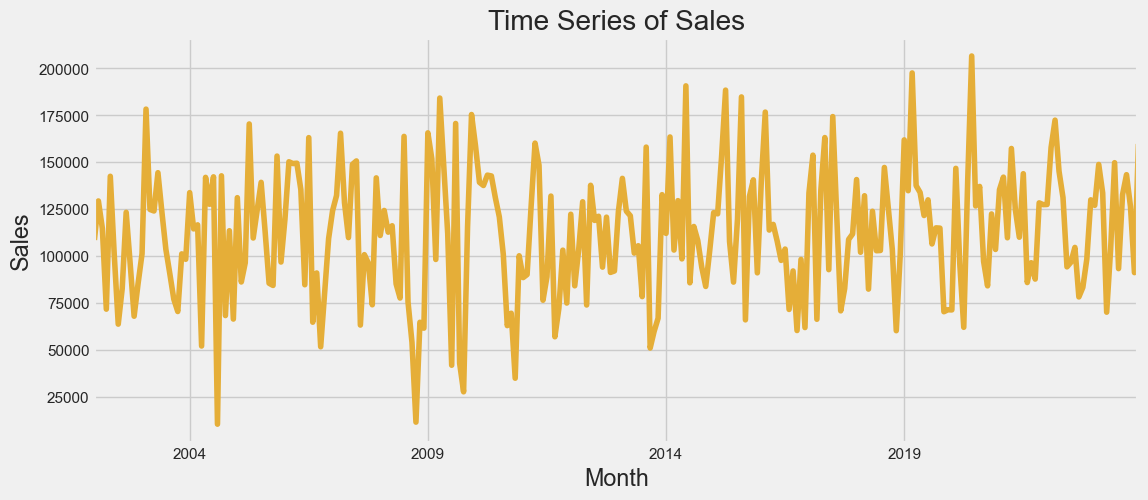

In [6]:
# plot the time series
color_pal = sns.color_palette()
sales_ts['Monthly Sales'].plot(style='-', figsize=(12,5), ms=2, title='Time Series of Sales', 
                               color= color_pal[2], ylabel='Sales');

## Decompose Time Series

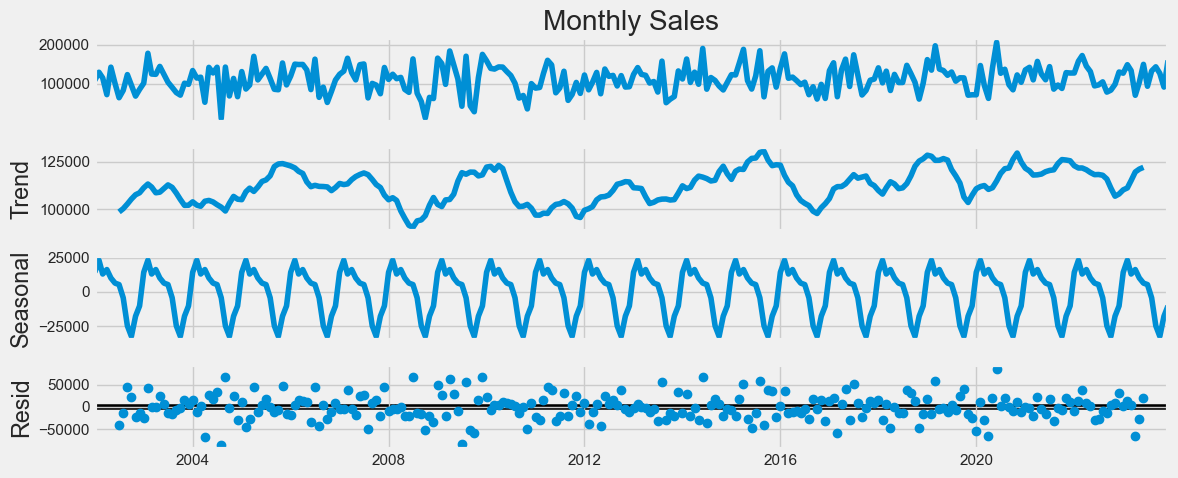

In [7]:
# decompose time series into components
sales_decompose = seasonal_decompose(sales_ts['Monthly Sales'], model='additive')

sales_decompose.plot()
plt.show()

In [8]:
# verify it's additive
sales_decompose.observed.iloc[45] == sales_decompose.trend.iloc[45] + sales_decompose.seasonal.iloc[45]\
                                            + sales_decompose.resid.iloc[45]

True

## Check for Stationary

In [9]:
# Check for stationarity by rolling windows
def check_stationary(df, col):
    df['rollmean'] = df[col].rolling(window=12).mean()
    df['rollstd'] = df[col].rolling(window=12).std()
    
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df, x=df.index, y=df[col], label='Time Series')
    sns.lineplot(data=df, x=df.index, y=df['rollmean'], label='Rolling Mean')
    sns.lineplot(data=df, x=df.index, y=df['rollstd'], label='Rolling Std');
    plt.title(label='Rolling Mean & Std')
    plt.legend()

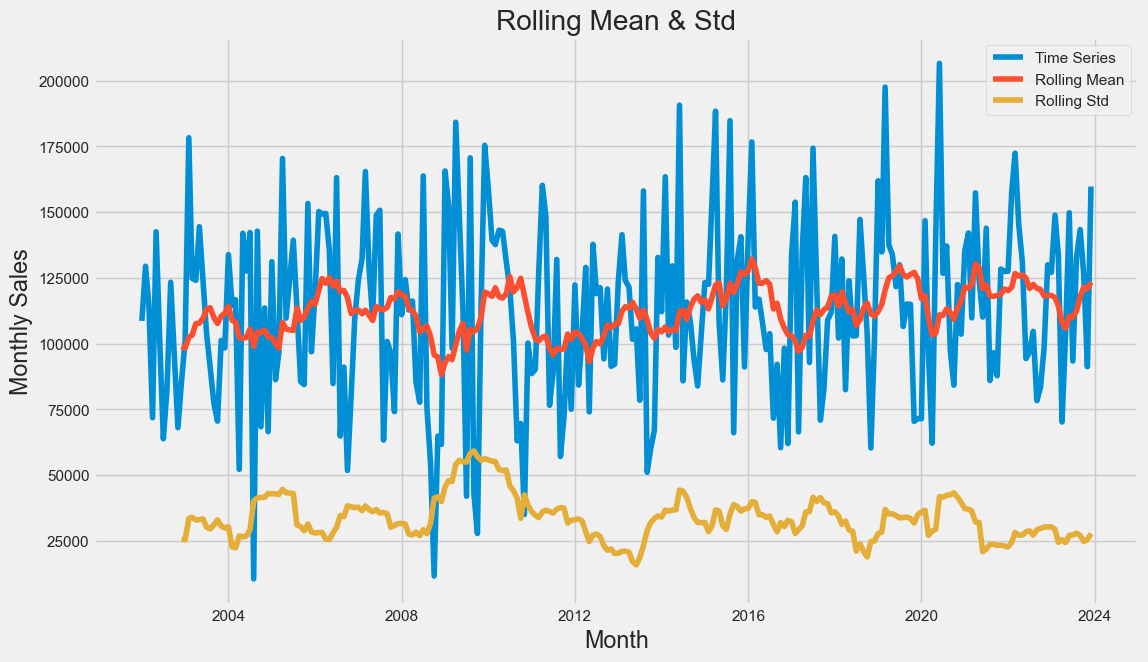

In [10]:
check_stationary(sales_ts, 'Monthly Sales')

## Tests for stationarity.
> **KPSS**:
>>*$H_{0}$*: *The data is stationary*.<br>
>>*$H_{1}$*: *The data is not stationary*.<br>
>
>
> **Adfuller**:<br>
>>*$H_{0}$*: *The data possesses a unit root is not stationary*.<br>
>>*$H_{1}$*: *The data is stationary*.


In [11]:
# import test libraries
from statsmodels.tsa.stattools import kpss, adfuller

# deactivate warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning, ConvergenceWarning
warnings.simplefilter('ignore', InterpolationWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [12]:
# function to test
def is_stationary(x):
    threshold = 0.05
    
    # for KPSS test
    stats, p, _, critical_val = kpss(x, 'ct')
    print(f'=======================KPSS=========================')
    print(f'Test Statistics = {stats}')
    print(f'p-value: {p}')
    print(f'Critical Values: {critical_val}')
    
    if p < threshold:
        kpss_log = f'For KPSS, Time Series is not stationary'
    else:
        kpss_log = f'For KPSS, Time Series is stationary'
    print(kpss_log)
        
    # for Adfuller test
    result = adfuller(x)
    print(f'\n====================Adfuller========================')
    print(f'Test Statistics = {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    
    if result[1] > threshold:
        adfull_log = f'For Adfuller, Time Series is not stationary'
    else:
        adfull_log = f'For Adfuller, Time Series is stationary'
    print(adfull_log)
          
    statement = 'Time Series is stationary'
    return (statement in kpss_log and statement in adfull_log)
        

In [13]:
is_stationary(sales_ts['Monthly Sales'])

=======================KPSS=========================
Test Statistics = 0.02700949774080778
p-value: 0.1
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
For KPSS, Time Series is stationary

====================Adfuller========================
Test Statistics = -4.471046070251255
p-value: 0.00022173509005268826
Critical Values: {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}
For Adfuller, Time Series is stationary


True

## Train/Test Split

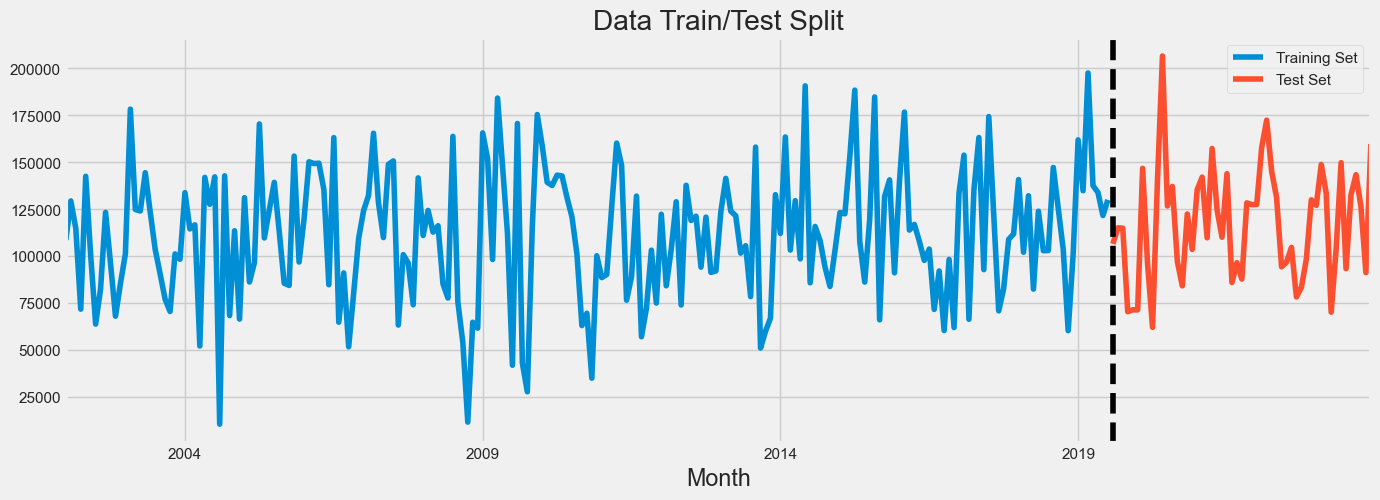

In [14]:
# split time series into train and test data
idx = round(len(sales_ts) * .8)
split_date = sales_ts.iloc[[idx]].index[0].strftime('%Y-%m-%d')
train = sales_ts[['Monthly Sales']][: idx]
test = sales_ts[['Monthly Sales']][idx:]

# visualise the train/test split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Implementing Holt Winters (ExponentialSmoothing)

### SimpleExpSmoothing

In [15]:
# import libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [16]:
# Fit simple model and get forecasts
model_simple = SimpleExpSmoothing(train['Monthly Sales'])
model_fit = model_simple.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])

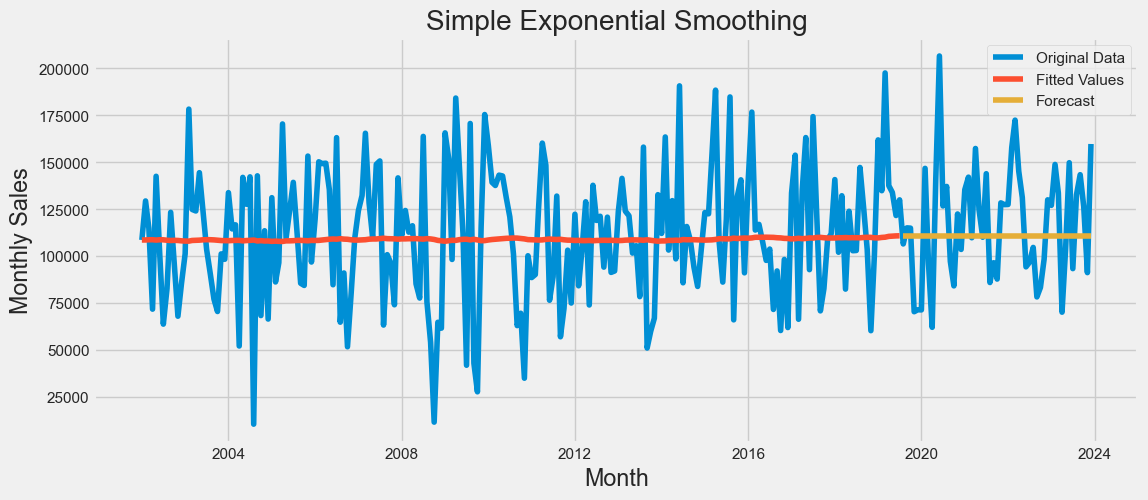

In [17]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values')
plt.plot(prediction, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

### Holt's Linear

In [18]:
# Fit simple model and get forecasts
model = Holt(train['Monthly Sales'], damped_trend=True)
model_holt = model.fit()
predict_holt = model_holt.predict(start=test.index[0], end=test.index[-1])

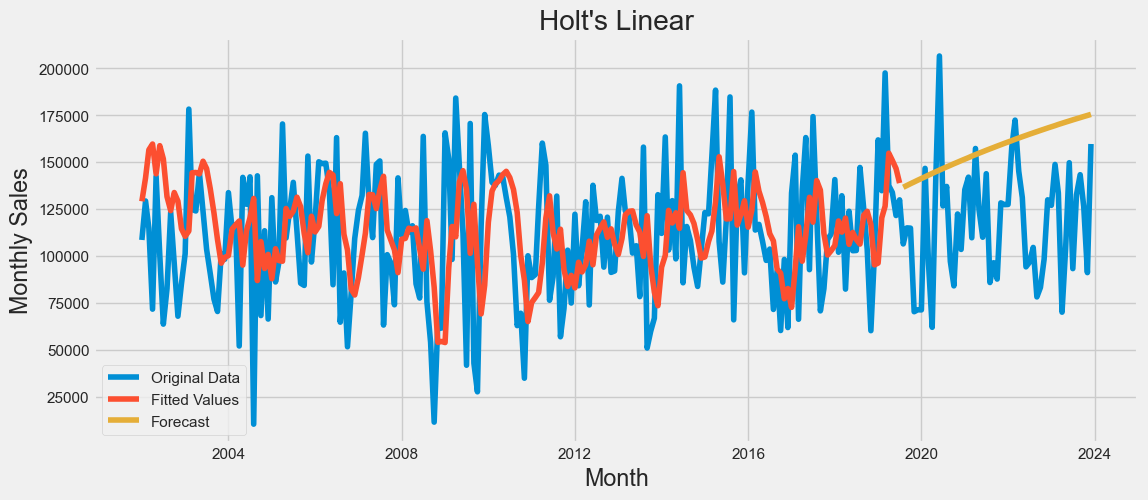

In [19]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_holt.fittedvalues, label='Fitted Values')
plt.plot(predict_holt, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title("Holt's Linear")
plt.legend()
plt.show()

### Exponential Smoothing

In [20]:
# Fit simple model and get forecasts
model = ExponentialSmoothing(train['Monthly Sales'], trend='add', seasonal='add', seasonal_periods=12)
model_holt_winters = model.fit()
predict_holt_winters = model_holt_winters.predict(start=test.index[0], end=test.index[-1])

#### Model Diagnostics

##### Some Diagnostic Functions

In [21]:
# function to visualise the residual
def plot_residual(the_model):
    residuals = the_model.resid[1:]
    fig, ax = plt.subplots(1,2)
    residuals.plot(title='Residual', ax=ax[0])
    residuals.plot(title='Density', kind='kde', ax=ax[1])
    plt.show()
    
# function to visualise the acf and pacf plots of the residual
def acf_pacf_residual_plot(the_model):
    acf_resid = plot_acf(the_model.resid)
    pacf_resid = plot_pacf(the_model.resid)

In [22]:
print(model_holt_winters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:            Monthly Sales   No. Observations:                  211
Model:             ExponentialSmoothing   SSE                   228988330194.531
Optimized:                         True   AIC                           4421.872
Trend:                         Additive   BIC                           4475.501
Seasonal:                      Additive   AICC                          4425.434
Seasonal Periods:                    12   Date:                 Wed, 15 Jan 2025
Box-Cox:                          False   Time:                         05:28:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0757143                alpha                 True
smoothing_trend          

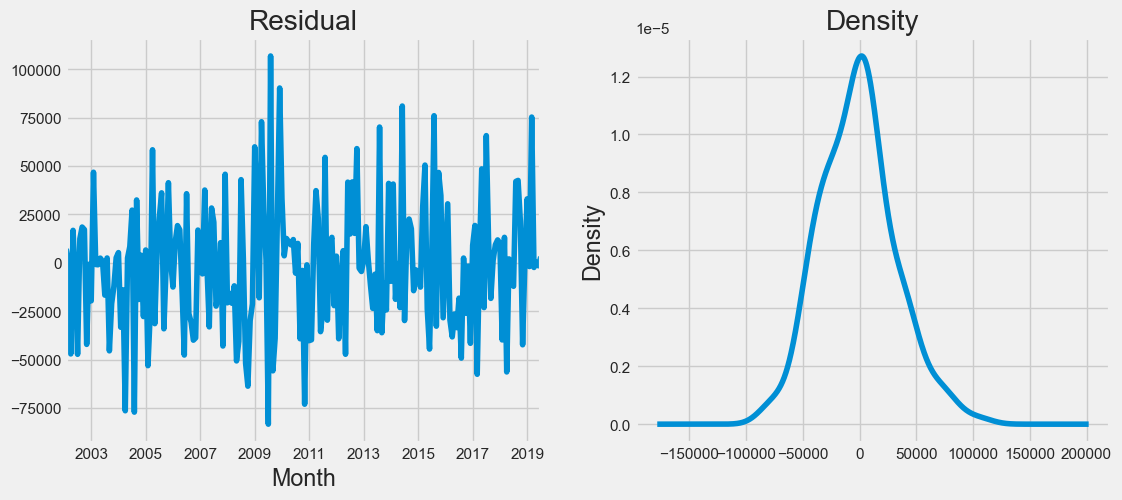

In [23]:
plot_residual(model_holt_winters)

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

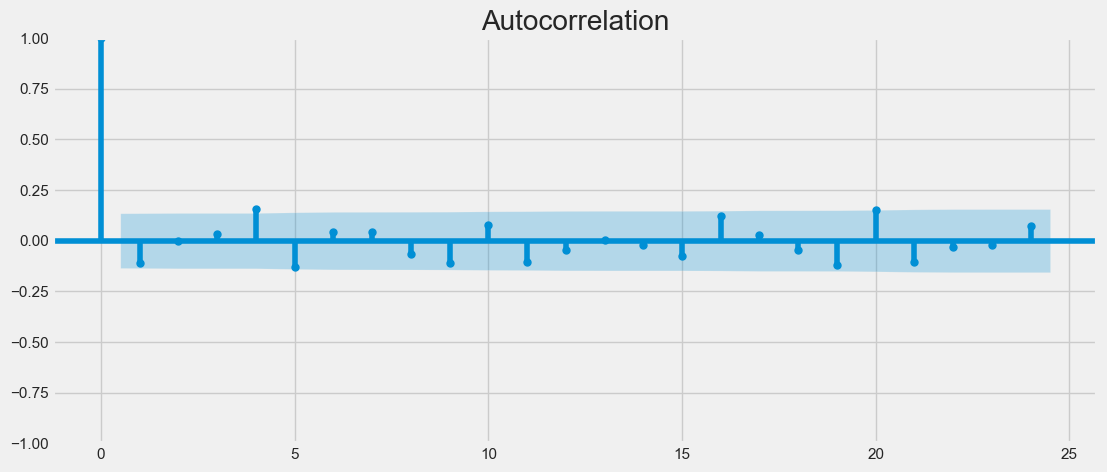

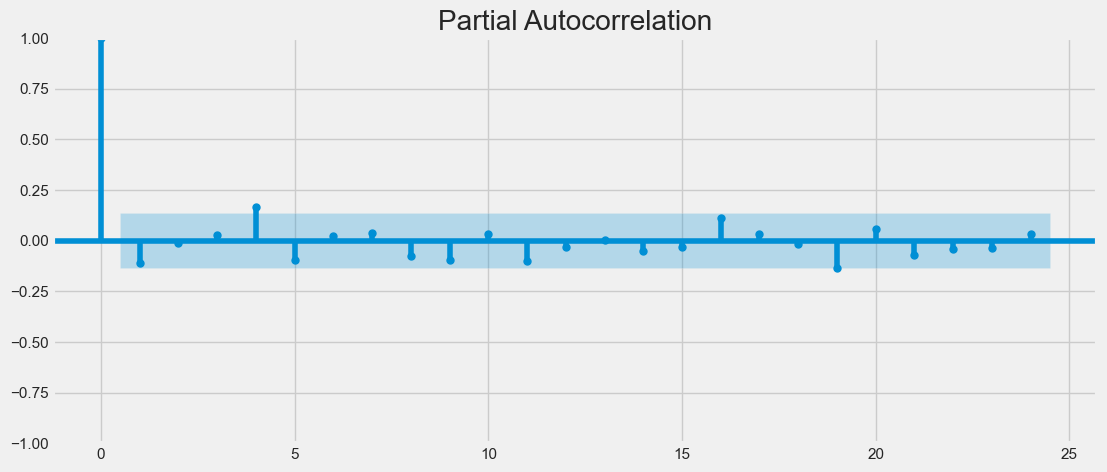

In [25]:
# plot acf and pacf for Exponential Smoothing residual
acf_pacf_residual_plot(model_holt_winters)

#### Prediction

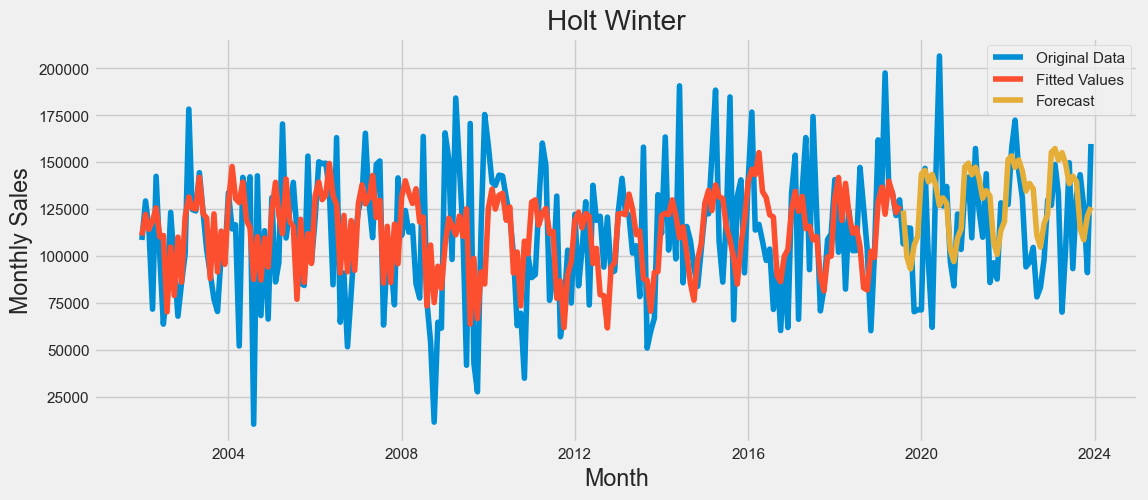

In [26]:
# plot the predicted time series with the original time series
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_holt_winters.fittedvalues, label='Fitted Values')
plt.plot(predict_holt_winters, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Holt Winter') 
plt.legend()
plt.show()

#### Evaluation

##### Some Evaluation Functions

In [27]:
# functions for evaluation
def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def evaluate_model(actual, pred, m_name, summary=False):
    mape_eval = mape(actual, pred)
    rmse = ms(actual, pred, square_root=True)
    sk_mape = mean_absolute_percentage_error(actual, pred)
    sk_mae = mean_absolute_error(actual, pred)
    sk_gmae = geometric_mean_absolute_error(actual, pred)

    print(f'The mean absolute percentage error for {m_name} = {mape_eval}')
    print(f'The root mean square error for {m_name} = {rmse}')
    print(f'The MAPE from sktime for {m_name} = {sk_mape}')
    print(f'The mean absolute error from sktime for {m_name} = {sk_mae}')
    print(f'The geometric mean absolute error from sktime for {m_name} = {sk_gmae}')
    
    if summary:
        return [m_name, rmse, sk_mape, sk_mae, sk_gmae]

In [28]:
# create the timestamp to forecasting
futuredate = pd.DataFrame(pd.date_range(start='2024-01-01', end='2024-04-01', freq='MS'), columns=['Dates'])
futuredate.set_index('Dates', inplace=True)
futuredate

Empty DataFrame
Columns: []
Index: [2024-01-01 00:00:00, 2024-02-01 00:00:00, 2024-03-01 00:00:00, 2024-04-01 00:00:00]

In [29]:
# forecast four months ahead for Exponential Smoothing
model_holt_winters.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    159122.458715
2024-02-01    161135.279139
2024-03-01    154997.840755
2024-04-01    158967.131288
Freq: MS, dtype: float64

In [30]:
# evaluate model
evaluate_model(test, predict_holt_winters, 'model_holt_winters')

The mean absolute percentage error for model_holt_winters = 29.768812851949267
The root mean square error for model_holt_winters = 31772.046435667984
The MAPE from sktime for model_holt_winters = 0.2518280073201425
The mean absolute error from sktime for model_holt_winters = 24549.70027470819
The geometric mean absolute error from sktime for model_holt_winters = 17517.312967907677






## ARIMA Model

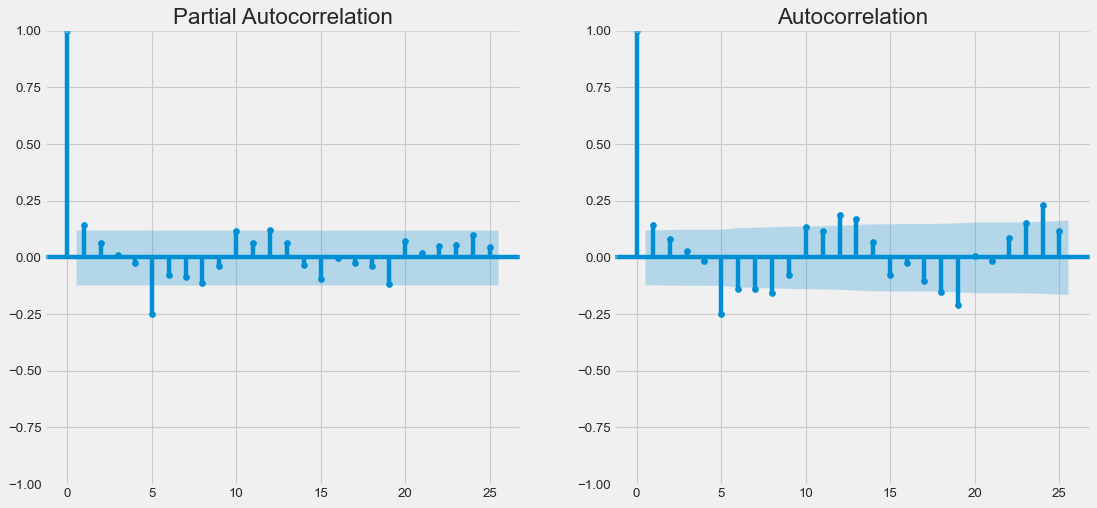

In [31]:
# plot the the correlation graphs
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7), dpi=80)
plot_pacf(sales_ts['Monthly Sales'], ax=ax1);
plot_acf(sales_ts['Monthly Sales'], ax=ax2);

# decorate
ax1.spines['top'].set_alpha(.3);ax2.spines['top'].set_alpha(.3)
ax1.spines['bottom'].set_alpha(.3);ax2.spines['bottom'].set_alpha(.3)
ax1.spines['right'].set_alpha(.3);ax2.spines['right'].set_alpha(.3)
ax1.spines['left'].set_alpha(.3);ax2.spines['left'].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

### Build Baseline ARIMA Model
- The most significant lag for the Pacf plot is 5. while the Acf is sinusoidal. Hence, the ARIMA model is ARIMA(5, 0, 5).

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# fit model to data and predict 
model_arima = ARIMA(train['Monthly Sales'], order=(5, 0, 5), trend='ct').fit()
predict_arima = model_arima.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

#### Model Diagnostics

In [33]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          Monthly Sales   No. Observations:                  211
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -2482.397
Date:                Wed, 15 Jan 2025   AIC                           4990.795
Time:                        05:29:37   BIC                           5034.369
Sample:                    01-01-2002   HQIC                          5008.408
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.055e+05   5416.428     19.473      0.000    9.49e+04    1.16e+05
x1            52.9138     45.130      1.172      0.241     -35.540     141.367
ar.L1         -0.5244      0.141     -3.728      0.0

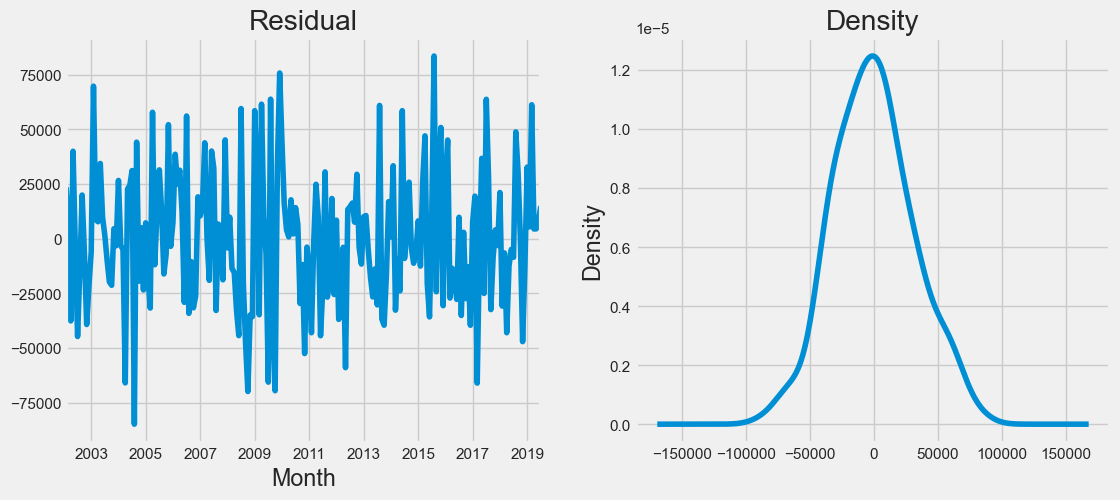

In [34]:
# plot the model's residual to check whether it's white noise
plot_residual(model_arima)

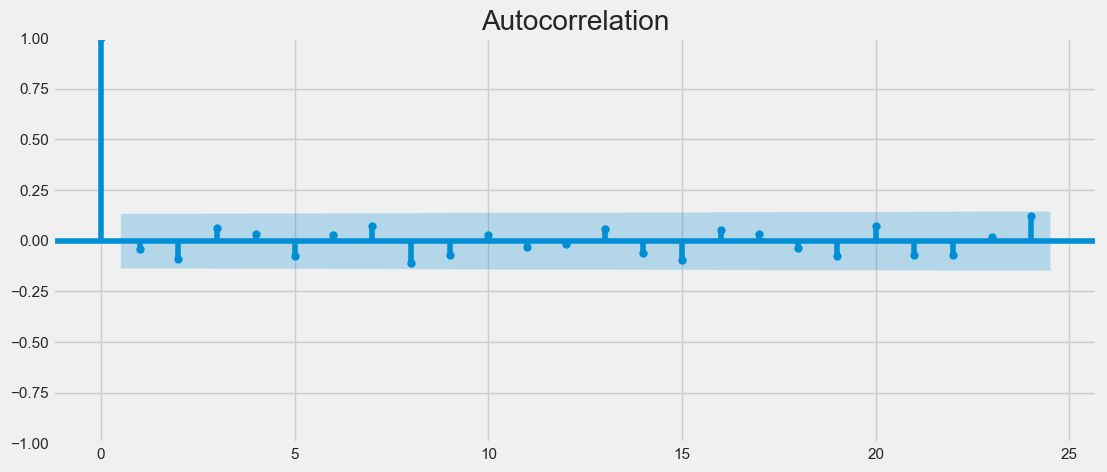

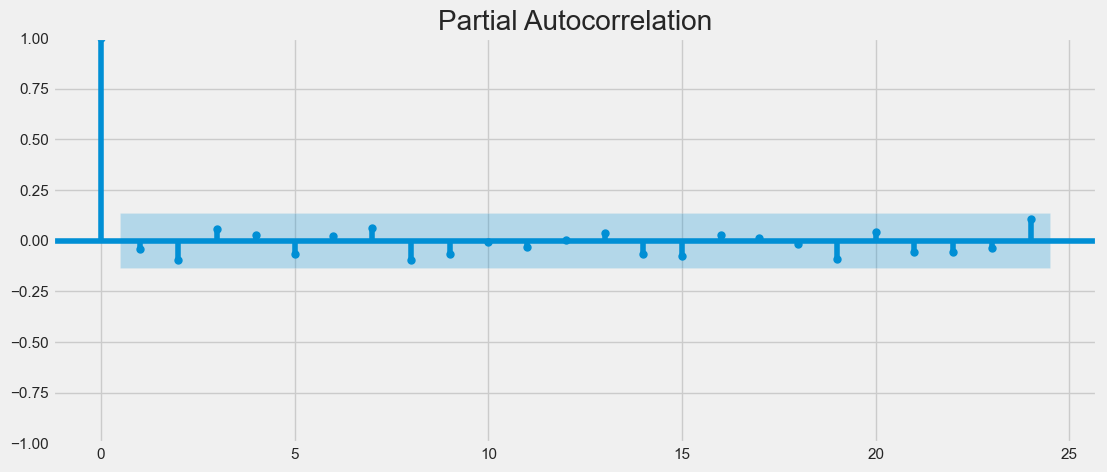

In [35]:
# plot acf and pacf for baseline ARIMA model's residual
acf_pacf_residual_plot(model_arima)

In [36]:
# forecast four months ahead with Arima
future_fcast = model_arima.predict(start=futuredate.index[0], end=futuredate.index[-1])

In [37]:
future_fcast

2024-01-01    129785.708069
2024-02-01    134697.377372
2024-03-01    137038.145395
2024-04-01    133974.495534
Freq: MS, Name: predicted_mean, dtype: float64

#### Prediction

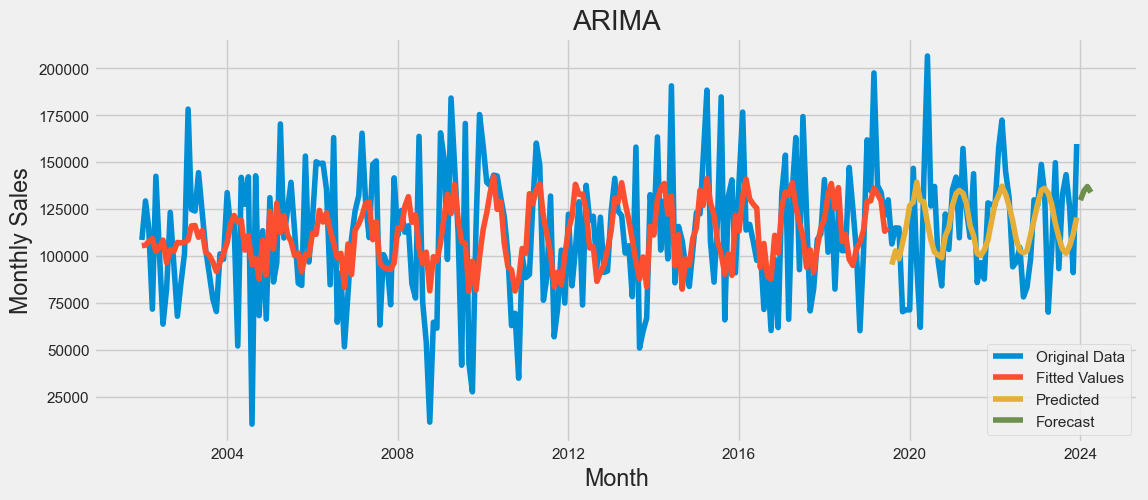

In [38]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_arima.fittedvalues, label='Fitted Values')
plt.plot(predict_arima, label='Predicted')
plt.plot(future_fcast, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('ARIMA') 
plt.legend()
plt.show()

#### Evaluation

In [39]:
# evaluate model
evaluate_model(test, predict_arima, 'model_arima')

The mean absolute percentage error for model_arima = 24.42007904413652
The root mean square error for model_arima = 28276.836994834888
The MAPE from sktime for model_arima = 0.21008359614259461
The mean absolute error from sktime for model_arima = 21892.570650031586
The geometric mean absolute error from sktime for model_arima = 14779.570364438978


### Searching for Optimal Parameters for ARIMA(p, d, q).

#### Define Parameter Space

In [40]:
# import utility library itertools
from itertools import product

# setting the parameter space for ARIMA
p = q = range(0, 20)
d = [0]
trend = ['t', 'ct']

pdq_tr = dict(parameters = list(product(p, d, q, trend)))

print(f'Instances of parameter combinations for Seasonal ARIMA...')
print(pdq_tr['parameters'][:5])

Instances of parameter combinations for Seasonal ARIMA...
[(0, 0, 0, 't'), (0, 0, 0, 'ct'), (0, 0, 1, 't'), (0, 0, 1, 'ct'), (0, 0, 2, 't')]


In [41]:
from sklearn.metrics import mean_squared_error
from mango import Tuner, scheduler

@scheduler.parallel(n_jobs=2)
def arima_objective_function(parameters):
    global data_values

    try:
        model = ARIMA(data_values, order=parameters[:-1], trend = parameters[-1])
        predictions = model.fit()
        mse = mean_squared_error(data_values, predictions.fittedvalues)
    except:
        mse = 1e10
    
    return mse

In [42]:
conf_Dict = dict()
conf_Dict['num_iteration'] = 200

In [43]:
data_values = list(train['Monthly Sales'])

In [44]:
tuner = Tuner(pdq_tr, arima_objective_function, conf_Dict)

In [45]:
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/200 [00:00<?, ?it/s]

best parameters: {'parameters': (18, 0, 16, 'ct')}
best loss: 830169344.321047


In [46]:
# fit final model to data and predict 
final_arima_model = ARIMA(train['Monthly Sales'], order=(18, 0, 16), trend='ct').fit()
predict_final_arima = final_arima_model.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

#### Model's Diagnostics

In [47]:
print(final_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:          Monthly Sales   No. Observations:                  211
Model:               ARIMA(18, 0, 16)   Log Likelihood               -2467.536
Date:                Wed, 15 Jan 2025   AIC                           5009.072
Time:                        05:52:51   BIC                           5133.090
Sample:                    01-01-2002   HQIC                          5059.203
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.055e+05   4140.835     25.472      0.000    9.74e+04    1.14e+05
x1            52.9252     47.995      1.103      0.270     -41.143     146.993
ar.L1         -0.4593      3.936     -0.117      0.9

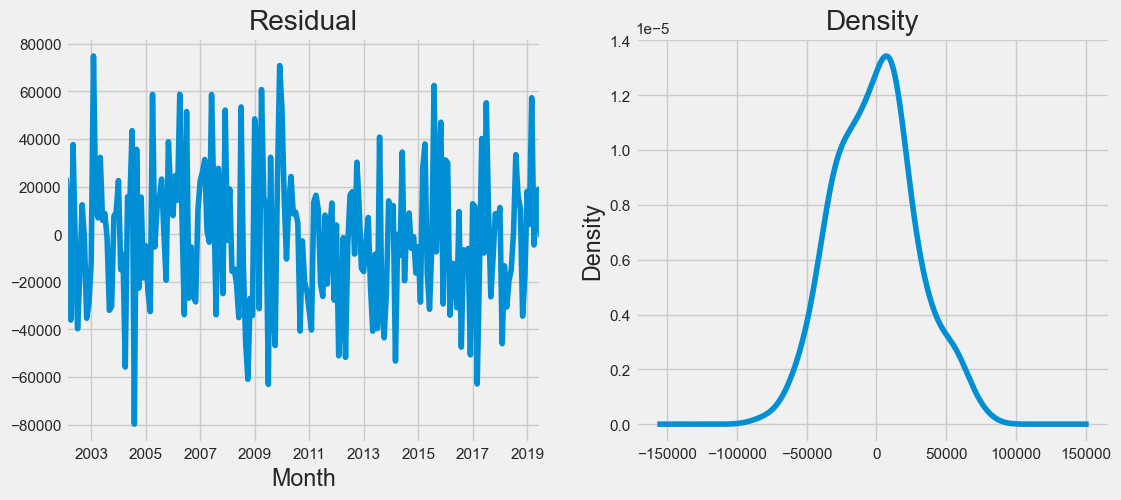

In [48]:
# plot the final_arima_model residual to check whether it's white noise
plot_residual(final_arima_model )

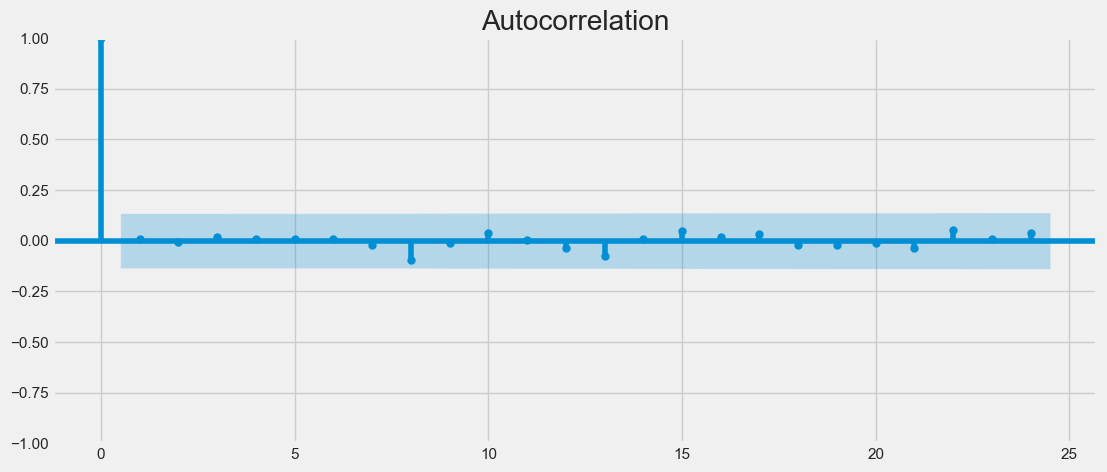

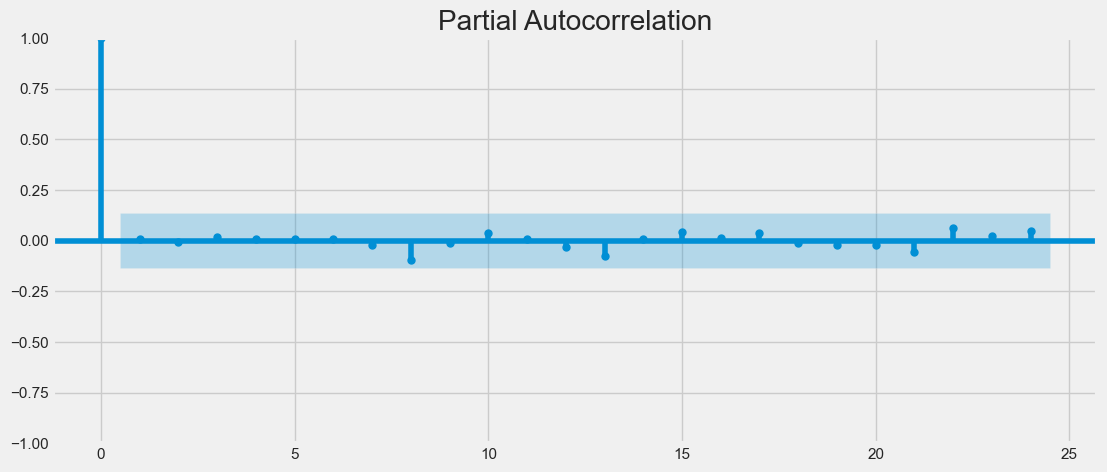

In [49]:
# plot acf and pacf for final_arima_model residual
acf_pacf_residual_plot(final_arima_model )

In [50]:
# forecast four months ahead with final Arima
future_final_fcast = final_arima_model.predict(start=futuredate.index[0], end=futuredate.index[-1])

In [51]:
future_final_fcast

2024-01-01    127752.943464
2024-02-01    144167.970891
2024-03-01    146935.321989
2024-04-01    130625.070344
Freq: MS, Name: predicted_mean, dtype: float64

#### Prediction

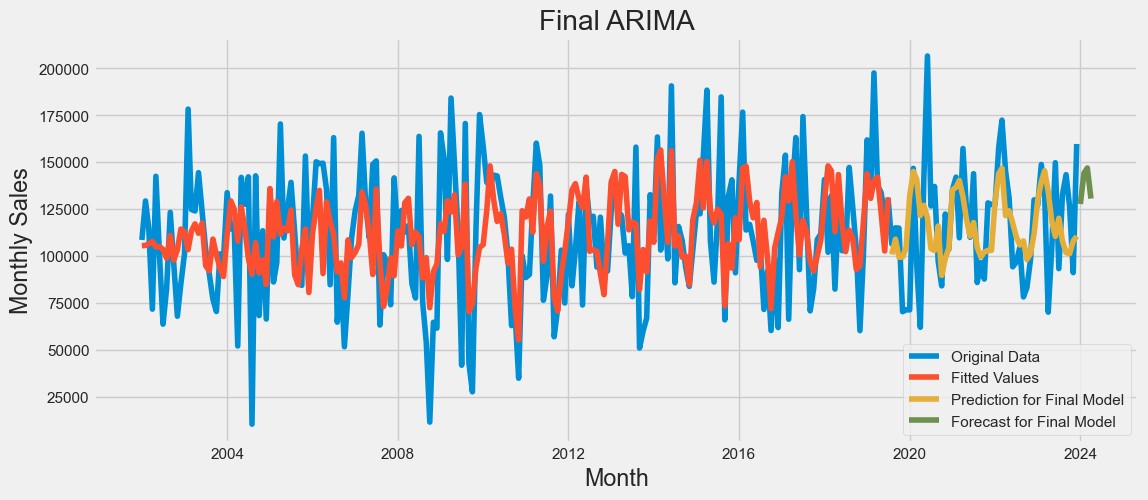

In [52]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(final_arima_model.fittedvalues, label='Fitted Values')
plt.plot(predict_final_arima, label='Prediction for Final Model')
plt.plot(future_final_fcast, label='Forecast for Final Model')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Final ARIMA') 
plt.legend()
plt.show()

#### Evaluate Model

In [53]:
# evaluate model
evaluate_model(test, predict_final_arima, 'final_arima_model')

The mean absolute percentage error for final_arima_model = 24.98981701146877
The root mean square error for final_arima_model = 28166.735942379742
The MAPE from sktime for final_arima_model = 0.20510908530479816
The mean absolute error from sktime for final_arima_model = 21578.607676413336
The geometric mean absolute error from sktime for final_arima_model = 12705.446415954088


## SARIMA

In [54]:
# import library
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [55]:
# setting the parameter space for SARIMAX
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]
print(f'Instances of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

Instances of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)


In [56]:
# search for optimal combination

params_grid = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=param,
                           seasonal_order=param_seasonal,
                           enforce_stationarity=False,
                            enforce_invertibility=False,)
            results = model.fit()
            params_grid[results.aic] = f'ARIMA {param}x{param_seasonal}'
            keys = sorted(params_grid.keys())
        except:
            continue

In [57]:
for param in [f'{params_grid[key]} : {key}' for key in keys[:5]]:
    print(param)

ARIMA (1, 1, 1)x(0, 1, 1, 12) : 4410.700905136976
ARIMA (1, 1, 1)x(1, 1, 1, 12) : 4411.887591987436
ARIMA (0, 1, 1)x(0, 1, 1, 12) : 4412.557144391163
ARIMA (0, 1, 1)x(1, 1, 1, 12) : 4413.6360887224455
ARIMA (0, 0, 1)x(1, 1, 1, 12) : 4427.694157365205


### Fitting the Sarima Model

In [58]:
# fit model to data
model_sarima = SARIMAX(train[['Monthly Sales']], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), 
                       enforce_stationarity=False, 
                        enforce_invertibility=False)
model_results = model_sarima.fit()

In [59]:
print(model_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2115      0.142     -1.487      0.137      -0.490       0.067
ma.L1         -0.7373      0.100     -7.374      0.000      -0.933      -0.541
ma.S.L12      -0.8101      0.078    -10.351      0.000      -0.963      -0.657
sigma2      2.188e+09   3.47e-12    6.3e+20      0.000    2.19e+09    2.19e+09


### Run Model Diagnostics

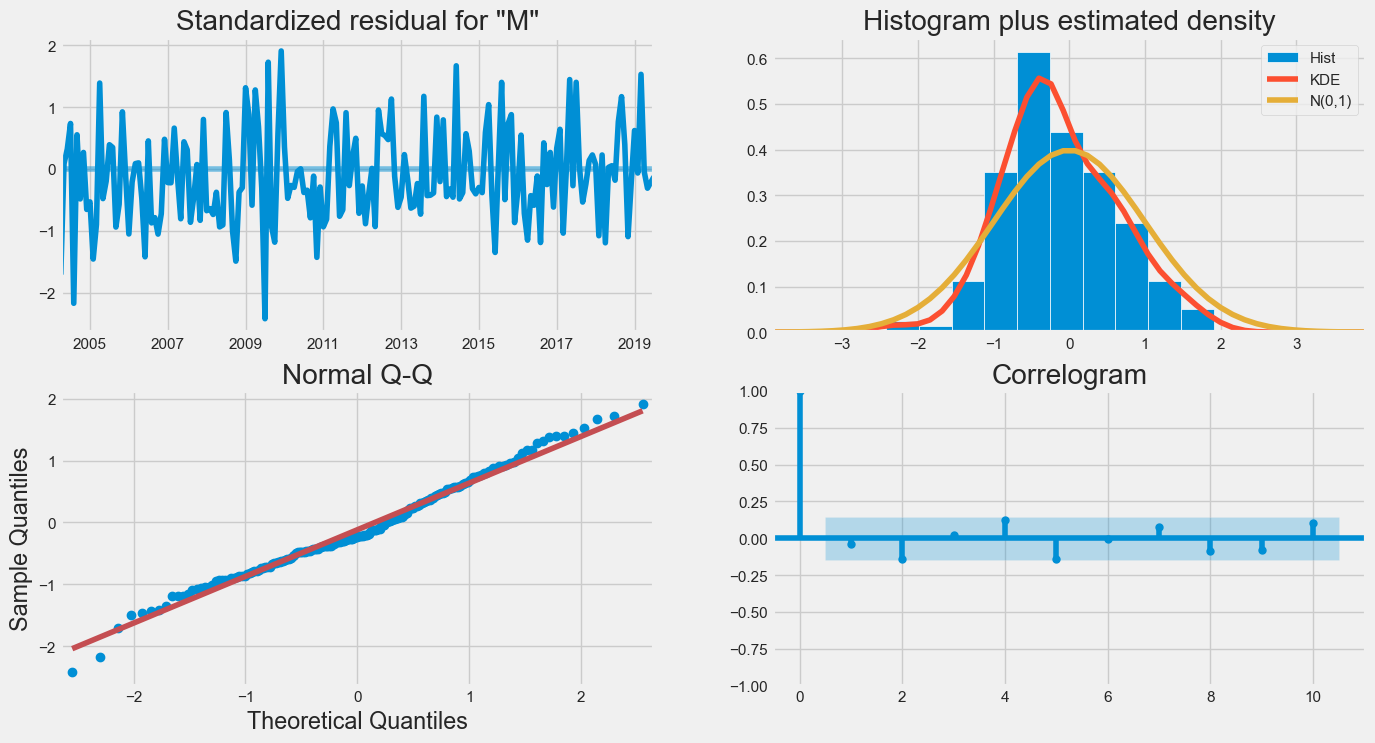

In [60]:
model_results.plot_diagnostics(figsize=(15, 8))
plt.show()

In [61]:
# fit final model to data and predict 
predict_sarima = model_results.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

### Forecasting

In [62]:
# forecast four months ahead with final Arima
future_sarima = model_results.predict(start=futuredate.index[0], end=futuredate.index[-1])

In [63]:
future_sarima

2024-01-01    175497.300444
2024-02-01    173036.916491
2024-03-01    170748.503081
2024-04-01    168987.069124
Freq: MS, Name: predicted_mean, dtype: float64

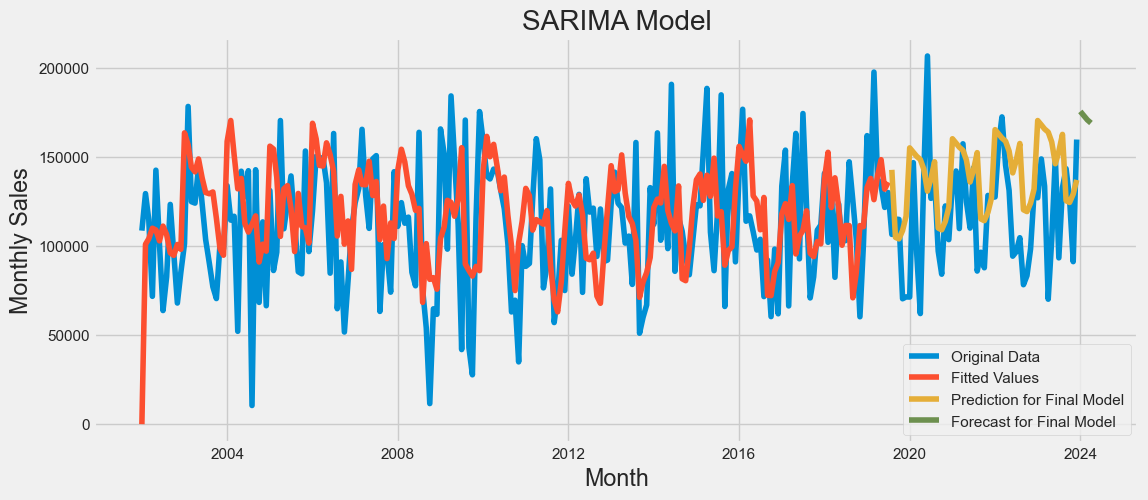

In [64]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_results.fittedvalues, label='Fitted Values')
plt.plot(predict_sarima, label='Prediction for Final Model')
plt.plot(future_sarima, label='Forecast for Final Model')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('SARIMA Model') 
plt.legend()
plt.show()

### Evaluate Model

In [65]:
# evaluate model
evaluate_model(test, predict_sarima, 'model_sarima')

The mean absolute percentage error for model_sarima = 35.03648533779991
The root mean square error for model_sarima = 37573.44360422857
The MAPE from sktime for model_sarima = 0.30566757500650843
The mean absolute error from sktime for model_sarima = 29442.07732147755
The geometric mean absolute error from sktime for model_sarima = 18628.456023312978


## Prophet Model

In [66]:
#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly

import plotly.express as px

In [67]:
# get the dataset into dataframe
df_sales = sales_ts[['Monthly Sales']]
df_sales = df_sales.reset_index().rename(columns={'Monthly Sales':'y','Month': 'ds'})

In [68]:
df_sales.set_index('ds', inplace=True)
df_sales.head()

y
ds                
2002-01-01  108592
2002-02-01  129387
2002-03-01  114777
2002-04-01   71738
2002-05-01  142512

### Split Train/Test

In [69]:
# split time series into train/test data using sktime module
y_train, y_test = temporal_train_test_split(df_sales, test_size=0.2)

### Build Model

In [70]:
# instantiate a model
model_naive = Prophet(interval_width=0.95)
model_naive.fit(y_train.reset_index())

06:00:50 - cmdstanpy - INFO - Chain [1] start processing
06:00:52 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
# create timestamps for test data
future = model_naive.make_future_dataframe(periods=len(y_test)+4, freq='MS')
future.tail()

ds
263 2023-12-01
264 2024-01-01
265 2024-02-01
266 2024-03-01
267 2024-04-01

In [72]:
# make prediction by the test data
forecast = model_naive.predict(future)
test_fcast = forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]
test_fcast_w = test_fcast.iloc[:-4]

In [73]:
test_fcast_w.tail()

ds    yhat_lower           yhat     yhat_upper
259 2023-08-01  54065.450063  114328.885166  169708.296567
260 2023-09-01  29903.123735   91577.060642  150111.874748
261 2023-10-01  28178.681364   83942.212415  142164.951533
262 2023-11-01  40897.092919   98867.165345  153526.796209
263 2023-12-01  46774.561430  107748.553652  165760.494392

In [74]:
forecast[['yhat']].iloc[-4:]

yhat
264  134798.355235
265  138423.233260
266  131101.573778
267  137279.434532

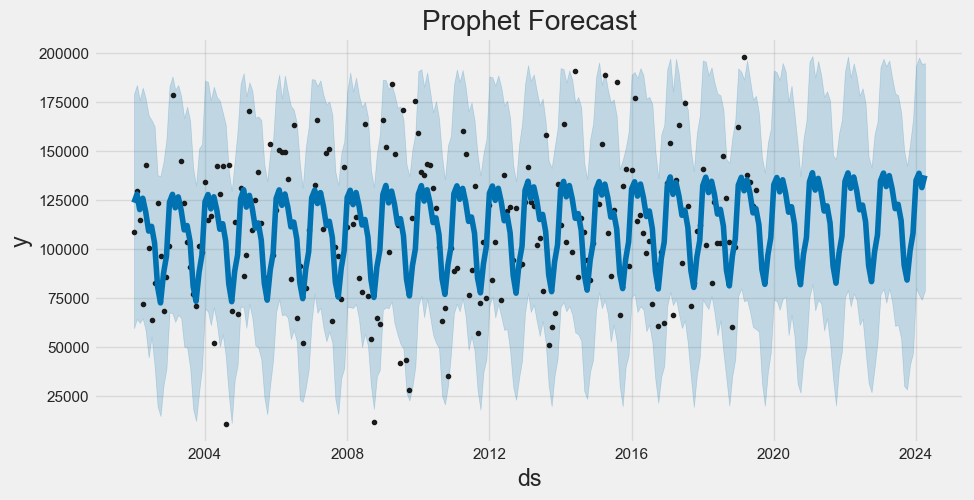

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_naive.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In [76]:
# concatenate the predicted data and the actual data
y_yhat = pd.concat([df_sales, test_fcast[['ds', 'yhat']].set_index('ds').loc[y_test.index[0]:]], axis=1)

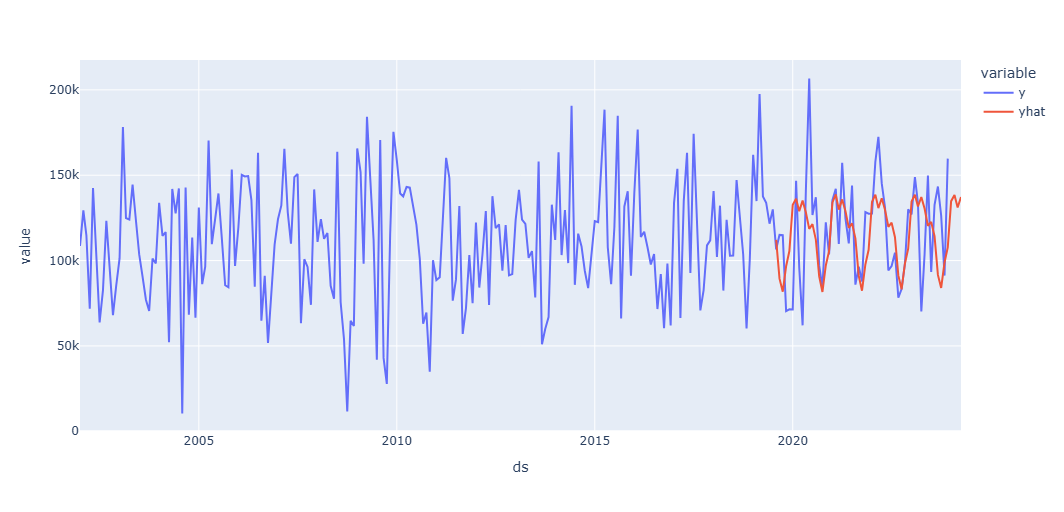

In [77]:
# visualise the actual sales with the predicted sales
fig = px.line(y_yhat, x=y_yhat.index, y=['y', 'yhat'], width=900, height=512)
fig.show()

#### Model Diagnostics

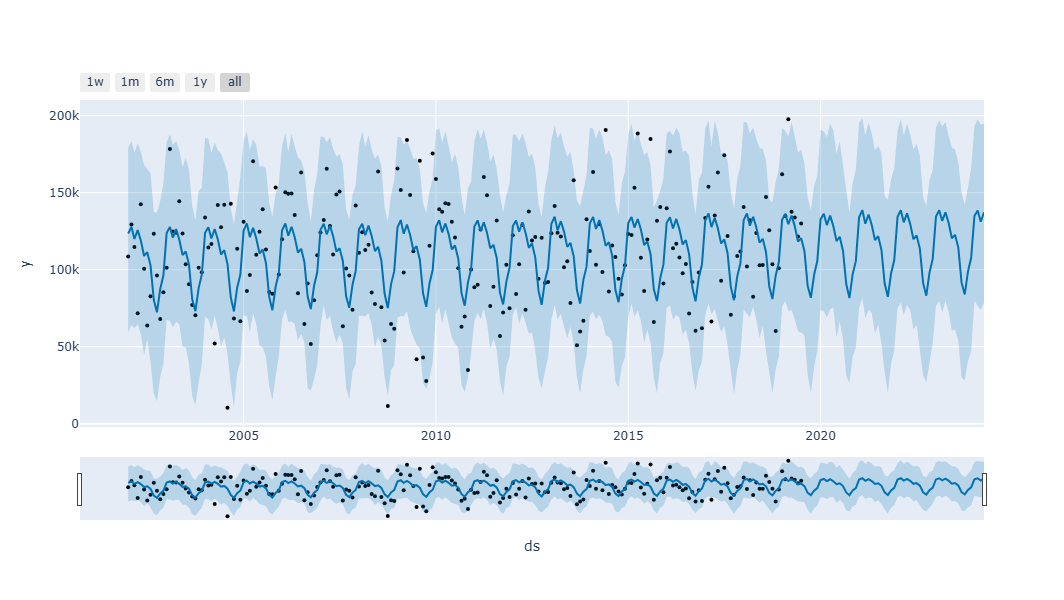

In [78]:
plot_plotly(model_naive, test_fcast)

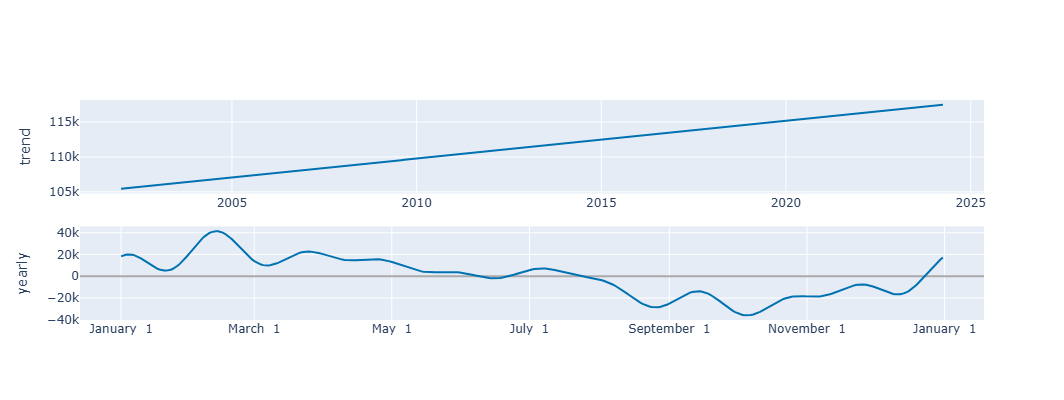

In [79]:
# plot the components of the time series
fig = plot_components_plotly(model_naive, forecast)
fig.show()

#### Compare Forecast to Actual

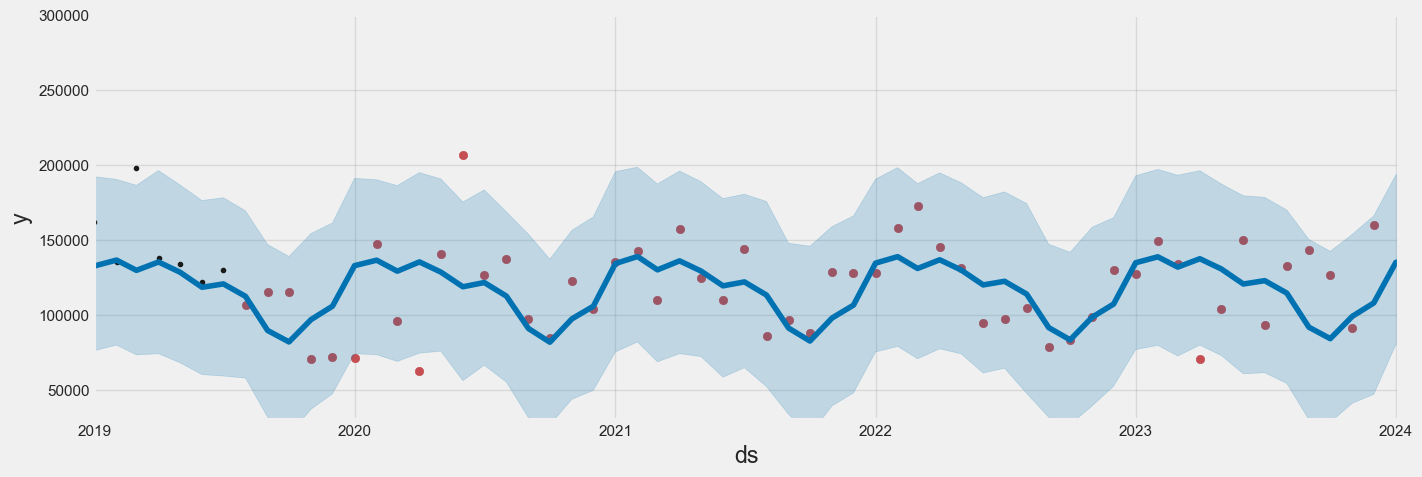

In [80]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(y_test.index, y_test['y'], color='r')
fig = model_naive.plot(test_fcast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2019'), upper=pd.to_datetime('01-06-2024'))
ax.set_ylim(30_000, 300_000);

#### Evaluate Naive Model

In [81]:
# Evaluate the naive model
filter = test_fcast['ds'] >= y_test.index[0]
predict_df = test_fcast[filter][['ds', 'yhat']]
predict_df = predict_df.merge(df_sales.reset_index(), on='ds')

In [82]:
evaluate_model(predict_df['y'], predict_df['yhat'], 'model_naive')

The mean absolute percentage error for model_naive = 20.677949775716424
The root mean square error for model_naive = 29407.407812888385
The MAPE from sktime for model_naive = 0.20677949775716425
The mean absolute error from sktime for model_naive = 21885.445455378747
The geometric mean absolute error from sktime for model_naive = 12268.014813654807


### Forecasting

In [83]:
# instantiate a model
model_naive_2 = Prophet(interval_width=0.95)
model_naive_2.fit(df_sales.reset_index())

06:03:05 - cmdstanpy - INFO - Chain [1] start processing
06:03:05 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# create timestamps for test data
future = model_naive_2.make_future_dataframe(periods=4, freq='MS')
future.tail()

ds
263 2023-12-01
264 2024-01-01
265 2024-02-01
266 2024-03-01
267 2024-04-01

In [85]:
# make prediction by the test data
forecast_2 = model_naive_2.predict(future)
test_fcast_2 = forecast_2[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

In [86]:
test_fcast_2[['yhat']].tail(4)

yhat
264  120748.903804
265  132596.848758
266  114721.489546
267  128168.189954

### Using Cross Validation

- To check those timestamps that are anomalies

In [87]:
model_cv = Prophet()
model_cv.fit(y_train.reset_index())
df_cv = cross_validation(model_cv, initial='420 days', period='60 days', horizon ='60 days')

06:03:24 - cmdstanpy - INFO - Chain [1] start processing
06:03:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/99 [00:00<?, ?it/s]

06:03:25 - cmdstanpy - INFO - Chain [1] start processing
06:03:43 - cmdstanpy - INFO - Chain [1] done processing
06:03:43 - cmdstanpy - INFO - Chain [1] start processing
06:04:07 - cmdstanpy - INFO - Chain [1] done processing
06:04:07 - cmdstanpy - INFO - Chain [1] start processing
06:04:13 - cmdstanpy - INFO - Chain [1] done processing
06:04:13 - cmdstanpy - INFO - Chain [1] start processing
06:04:35 - cmdstanpy - INFO - Chain [1] done processing
06:04:36 - cmdstanpy - INFO - Chain [1] start processing
06:05:00 - cmdstanpy - INFO - Chain [1] done processing
06:05:01 - cmdstanpy - INFO - Chain [1] start processing
06:05:01 - cmdstanpy - INFO - Chain [1] done processing
06:05:01 - cmdstanpy - INFO - Chain [1] start processing
06:05:02 - cmdstanpy - INFO - Chain [1] done processing
06:05:02 - cmdstanpy - INFO - Chain [1] start processing
06:05:02 - cmdstanpy - INFO - Chain [1] done processing
06:05:03 - cmdstanpy - INFO - Chain [1] start processing
06:05:03 - cmdstanpy - INFO - Chain [1]

In [88]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   7 days  1.653884e+09  40667.969381  33407.674184  0.344199  0.218131   
1   8 days  6.675287e+09  81702.431987  52977.904048  0.663241  0.259730   
2   9 days  6.595977e+09  81215.620800  52712.079968  0.665035  0.273526   
3  10 days  6.745747e+09  82132.494486  54158.472019  0.728217  0.284906   
4  11 days  6.810460e+09  82525.508597  53448.448240  0.677286  0.297507   
5  12 days  6.614109e+09  81327.170512  50862.487035  0.638297  0.297507   
6  13 days  6.615301e+09  81334.498292  50894.826764  0.835564  0.297507   
7  14 days  1.905792e+09  43655.379622  35062.075780  0.560643  0.218511   
8  15 days  1.917098e+09  43784.673599  35326.752325  0.574450  0.245644   
9  16 days  1.964060e+09  44317.711959  34979.105029  0.603445  0.245644   
10 17 days  2.257118e+09  47509.131008  36895.458711  0.645774  0.245966   
11 18 days  2.569522e+09  50690.455909  41124.361289  0.607559  0.373651   
12 19 days  2.356635e+09  48545.188761  37370.518662  0.470929  0.373651   
13 20 days  2.075825e+09  45561.221803  34261.542113  0.435965  0.294469   
14 21 days  1.689995e+09  41109.547315  30514.254428  0.361807  0.279541   
15 22 days  1.001977e+09  31654.019520  23697.787455  0.261025  0.120299   
16 23 days  8.284782e+08  28783.297929  22518.848826  0.259696  0.120299   
17 24 days  8.083904e+08  28432.207260  22539.838126  0.278527  0.120299   
18 25 days  8.396817e+08  28977.262301  23399.250074  0.280440  0.131464   
19 26 days  8.485096e+08  29129.187606  22969.860527  0.266413  0.131464   
20 27 days  8.250792e+08  28724.192514  22078.918782  0.253002  0.167173   
21 28 days  7.939290e+08  28176.744892  21098.047668  0.245077  0.131464   
22 29 days  6.228829e+08  24957.622892  18133.571250  0.196192  0.117346   
23 30 days  5.210636e+08  22826.817321  15854.176074  0.160606  0.076264   
24 31 days  5.556914e+08  23573.107677  16608.236795  0.186082  0.076264   
25 32 days  5.173194e+08  22744.655583  16330.278384  0.195190  0.149923   
26 33 days  6.338435e+08  25176.248816  18634.441321  0.230495  0.195152   
27 34 days  6.350430e+08  25200.060248  19481.882971  0.242981  0.196471   
28 35 days  7.740796e+08  27822.286879  22082.074681  0.487590  0.226933   
29 36 days  7.366405e+08  27141.121798  22397.673775  0.487781  0.226933   
30 37 days  9.813415e+08  31326.371269  26098.052121  0.504530  0.233295   
31 38 days  1.176758e+09  34303.902913  26999.540460  0.503236  0.226933   
32 39 days  1.588025e+09  39850.028553  29999.346183  0.505126  0.233295   
33 40 days  2.457630e+09  49574.486457  37679.652952  0.607002  0.243649   
34 41 days  2.976396e+09  54556.351902  41819.339835  0.392759  0.281528   
35 42 days  3.548896e+09  59572.612175  46788.861091  0.420674  0.351239   
36 43 days  3.245099e+09  56965.772152  42748.955530  0.387171  0.281528   
37 44 days  3.160950e+09  56222.327449  42911.903120  0.376499  0.281528   
38 45 days  2.843082e+09  53320.560740  39827.834184  0.351351  0.281528   
39 46 days  2.003828e+09  44764.131977  31862.541790  0.254242  0.143106   
40 47 days  1.350103e+09  36743.741272  25736.549278  0.209540  0.143106   
41 48 days  1.264040e+09  35553.336859  26934.510966  0.266041  0.176948   
42 49 days  1.470615e+09  38348.603954  30606.348163  0.298852  0.217243   
43 50 days  1.363505e+09  36925.670598  31082.295842  0.283996  0.247920   
44 51 days  1.236784e+09  35167.935601  29939.386110  0.279317  0.217243   
45 52 days  1.299926e+09  36054.482031  30992.641877  0.288924  0.247920   
46 53 days  1.150916e+09  33925.148901  28265.382808  0.258473  0.247920   
47 54 days  8.837785e+08  29728.412331  24219.019632  0.206117  0.191646   
48 55 days  7.812302e+08  27950.494773  23475.218982  0.209838  0.201300   
49 56 days  8.116110e+08  28488.786976  23553.607616  0.215775  0.201300   
50 57 days  8.503208e+08  29160.260524  24303.997475  0.214485  0.221339   
51 58 days  1.089971e+09  33014.705544  27279.22641

In [89]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

ds           yhat    yhat_lower     yhat_upper       y     cutoff  \
19  2004-11-01   16551.046044   -263.784757   35432.853122  113510 2004-09-17   
15  2004-07-01   37692.463588  21639.855568   51832.611699  142221 2004-05-20   
9   2004-01-01   41801.141647  41001.348656   42578.313485  133804 2003-11-22   
28  2005-08-01   43828.925800  19086.755273   69642.923115  113140 2005-07-14   
24  2005-04-01   70798.639681  49717.877649   92017.482914  170386 2005-03-16   
76  2009-08-01   72055.235060  37801.516233  104582.743948  170648 2009-06-23   
80  2009-12-01   88181.569185  50297.326331  125380.446134  175416 2009-10-21   
114 2012-10-01   63683.106881  24206.499360  103092.763174  120734 2012-08-06   
148 2015-08-01  101029.217617  61312.942000  138346.313756  184786 2015-07-22   
150 2015-10-01   74230.715088  34742.146573  113187.094818  131721 2015-09-20   

          mape  overestimate  
19   85.418865         False  
15   73.497259         False  
9    68.759423         False  
28   61.261335         False  
24   58.448089         False  
76   57.775517         False  
80   49.730031         False  
114  47.253378         False  
148  45.326368         False  
150  43.645497         False

### Hyperparameters Tuning

In [90]:
# set values for some hyperparameters
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [91]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
# holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
print(seasonality_prior_scale_range)

[0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]


In [92]:
start_time = time.time()

# parameter space
param_grid = {"changepoint_prior_scale": changepoint_prior_scale_range,
              "seasonality_prior_scale": seasonality_prior_scale_range }
        
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    model_hcv = Prophet(**params, interval_width=.95).fit(df_sales.reset_index())  # Fit model with given params
    df_hcv = cross_validation(model_hcv, initial='720 days', period='180 days', horizon = '300 days', parallel='processes')
    df_hp = performance_metrics(df_hcv, rolling_window=1)
    print(df_hp)
    rmses.append(df_hp["rmse"].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["rmse"] = rmses

print(tuning_results.head())
params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])

print("--- %s seconds ---" % (time.time() - start_time)) #about 5 minutes

06:11:21 - cmdstanpy - INFO - Chain [1] start processing
06:11:21 - cmdstanpy - INFO - Chain [1] done processing
06:11:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:11:21 - cmdstanpy - INFO - Chain [1] start processing
06:11:23 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.129623e+09  33609.863473  27025.838344  0.324415  0.193534   

      smape  coverage  
0  0.251205   0.94026  


06:12:24 - cmdstanpy - INFO - Chain [1] start processing
06:12:24 - cmdstanpy - INFO - Chain [1] done processing
06:12:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:24 - cmdstanpy - INFO - Chain [1] start processing
06:12:26 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.268055e+09  35609.755583  27432.401174  0.311462  0.183343   

      smape  coverage  
0  0.258708  0.844156  


06:12:58 - cmdstanpy - INFO - Chain [1] start processing
06:12:58 - cmdstanpy - INFO - Chain [1] done processing
06:12:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:58 - cmdstanpy - INFO - Chain [1] start processing
06:12:59 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse         rmse           mae      mape    mdape  \
0 300 days  1.288950e+09  35901.95375  27573.751638  0.312353  0.18869   

      smape  coverage  
0  0.260384  0.846753  


06:13:25 - cmdstanpy - INFO - Chain [1] start processing
06:13:25 - cmdstanpy - INFO - Chain [1] done processing
06:13:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:13:25 - cmdstanpy - INFO - Chain [1] start processing
06:13:26 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.324808e+09  36397.908322  27723.960176  0.311643  0.184263   

     smape  coverage  
0  0.26189  0.851948  


06:13:53 - cmdstanpy - INFO - Chain [1] start processing
06:13:53 - cmdstanpy - INFO - Chain [1] done processing
06:13:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:13:53 - cmdstanpy - INFO - Chain [1] start processing
06:13:54 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.310966e+09  36207.268957  27643.440574  0.311446  0.186215   

      smape  coverage  
0  0.261419  0.849351  


06:14:30 - cmdstanpy - INFO - Chain [1] start processing
06:14:30 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse         rmse           mae     mape     mdape  \
0 300 days  1.117839e+09  33434.09809  26868.917849  0.32265  0.192756   

      smape  coverage  
0  0.249489  0.937662  


06:14:51 - cmdstanpy - INFO - Chain [1] start processing
06:14:51 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.261398e+09  35516.169478  27143.675385  0.301315  0.187048   

      smape  coverage  
0  0.258544  0.857143  


06:15:13 - cmdstanpy - INFO - Chain [1] start processing
06:15:13 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.270045e+09  35637.694032  27155.865841  0.301765  0.183193   

      smape  coverage  
0  0.258201   0.85974  


06:15:41 - cmdstanpy - INFO - Chain [1] start processing
06:15:42 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.278174e+09  35751.560275  27198.308166  0.300507  0.184649   

      smape  coverage  
0  0.259272  0.841558  


06:16:05 - cmdstanpy - INFO - Chain [1] start processing
06:16:06 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.284533e+09  35840.381037  27228.217727  0.301154  0.185933   

      smape  coverage  
0  0.259178  0.851948  


06:16:28 - cmdstanpy - INFO - Chain [1] start processing
06:16:28 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse         rmse          mae      mape     mdape  \
0 300 days  1.140208e+09  33766.96782  27138.69684  0.325065  0.197506   

      smape  coverage  
0  0.251905  0.937662  


06:16:50 - cmdstanpy - INFO - Chain [1] start processing
06:16:50 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae     mape     mdape  \
0 300 days  1.300846e+09  36067.241326  27716.863823  0.30219  0.195819   

      smape  coverage  
0  0.265328  0.854545  


06:17:12 - cmdstanpy - INFO - Chain [1] start processing
06:17:13 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.312855e+09  36233.338333  27740.077426  0.301754  0.198111   

      smape  coverage  
0  0.265417   0.85974  


06:17:34 - cmdstanpy - INFO - Chain [1] start processing
06:17:35 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.314850e+09  36260.853836  27798.311499  0.303654  0.195428   

      smape  coverage  
0  0.265804  0.857143  


06:17:55 - cmdstanpy - INFO - Chain [1] start processing
06:17:56 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.321184e+09  36348.100851  27828.329879  0.302329  0.197417   

      smape  coverage  
0  0.266195  0.849351  


06:18:18 - cmdstanpy - INFO - Chain [1] start processing
06:18:19 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape  mdape  \
0 300 days  1.177044e+09  34308.067667  27571.954815  0.328035  0.204   

      smape  coverage  
0  0.255792  0.919481  


06:18:40 - cmdstanpy - INFO - Chain [1] start processing
06:18:40 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse        rmse          mae      mape     mdape  \
0 300 days  1.326142e+09  36416.2361  28044.36563  0.303303  0.202586   

      smape  coverage  
0  0.268542  0.846753  


06:19:01 - cmdstanpy - INFO - Chain [1] start processing
06:19:01 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.335405e+09  36543.195769  28089.235891  0.303214  0.200258   

      smape  coverage  
0  0.268874  0.841558  


06:19:23 - cmdstanpy - INFO - Chain [1] start processing
06:19:23 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.339876e+09  36604.312169  28120.807019  0.303591  0.198321   

      smape  coverage  
0  0.268955  0.836364  


06:19:44 - cmdstanpy - INFO - Chain [1] start processing
06:19:45 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.347329e+09  36705.985334  28171.265239  0.302854  0.198488   

      smape  coverage  
0  0.269481  0.851948  


06:20:05 - cmdstanpy - INFO - Chain [1] start processing
06:20:05 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.200986e+09  34655.240886  27799.035992  0.329362  0.209123   

      smape  coverage  
0  0.257907   0.92987  


06:20:28 - cmdstanpy - INFO - Chain [1] start processing
06:20:28 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.368314e+09  36990.731963  28387.516771  0.304353  0.206814   

      smape  coverage  
0  0.272487  0.844156  


06:20:51 - cmdstanpy - INFO - Chain [1] start processing
06:20:52 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse         rmse           mae      mape     mdape  \
0 300 days  1.386359e+09  37233.83645  28480.008913  0.304679  0.205174   

      smape  coverage  
0  0.273486  0.849351  


06:21:21 - cmdstanpy - INFO - Chain [1] start processing
06:21:21 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse         mae      mape     mdape  \
0 300 days  1.391388e+09  37301.308277  28545.4031  0.304872  0.204273   

      smape  coverage  
0  0.274124  0.828571  


06:21:47 - cmdstanpy - INFO - Chain [1] start processing
06:21:48 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae     mape     mdape  \
0 300 days  1.395730e+09  37359.466532  28553.962354  0.30498  0.205933   

      smape  coverage  
0  0.274119  0.838961  
   changepoint_prior_scale  seasonality_prior_scale          rmse
0                    0.001                   0.0100  33609.863473
1                    0.001                   2.5075  35609.755583
2                    0.001                   5.0050  35901.953750
3                    0.001                   7.5025  36397.908322
4                    0.001                  10.0000  36207.268957
--- 650.6046669483185 seconds ---


In [93]:
params_dict

{'changepoint_prior_scale': 0.12575,
 'seasonality_prior_scale': 0.01,
 'rmse': 33434.098090181855}

#### Promotion and Holiday Data

In [94]:
hol_dates = sales_data[sales_data['Holiday'] == 1]['Month']

In [95]:
# Create a DataFrame of holidays with date and holiday name
holidays = pd.DataFrame({'holiday': 'popular_holidays',
                        'ds': pd.to_datetime(hol_dates), # ADD YOUR CUSTOM HOLIDAYS
                        'lower_window': -3,
                        'upper_window': 1})

holidays.reset_index(drop=True, inplace=True)

In [96]:
# get the promo data into a series
promo_data = sales_data['Promotion']

In [97]:
# create the promo dataframe
promo_regressor_df = pd.DataFrame({'ds': sales_data['Month'], 'is_promo': promo_data})
promo_regressor_df.tail()

ds  is_promo
259 2023-08-01         0
260 2023-09-01         0
261 2023-10-01         1
262 2023-11-01         0
263 2023-12-01         0

### Backtesting with Tuned Metrics

In [98]:
# instantiate a model
model_bt = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'], 
                   seasonality_prior_scale=params_dict['seasonality_prior_scale'], interval_width=.95, holidays=holidays)

# add the promotion feature to the model
model_bt.add_regressor('is_promo')

# add the promotion feature to the training data
y_train_new = y_train.reset_index()
y_train_new['is_promo'] = promo_regressor_df['is_promo'][promo_regressor_df['ds'] < y_test.index[0]]

# Fit model with given params
model_bt.fit(y_train_new) 

# add the promotion feature to the test data
future['is_promo'] = promo_regressor_df['is_promo']
future['is_promo'].fillna(value=0, inplace=True)
    
forecast_bt = model_bt.predict(future)
test_fcast_bt = forecast_bt[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

06:26:44 - cmdstanpy - INFO - Chain [1] start processing
06:26:44 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
# Evaluate the backtesting model
filter = test_fcast_bt['ds'] >= y_test.index[0] 
predict_bt_df = test_fcast_bt[filter][['ds', 'yhat']]
predict_bt_df = predict_bt_df.merge(df_sales.reset_index(), on='ds')

#### Evaluation

In [100]:
# evaluate model_bt
evaluate_model(predict_bt_df['y'], predict_bt_df['yhat'], 'model_bt')

The mean absolute percentage error for model_bt = 21.926246240912356
The root mean square error for model_bt = 28376.489542041036
The MAPE from sktime for model_bt = 0.21926246240912356
The mean absolute error from sktime for model_bt = 23049.43065273074
The geometric mean absolute error from sktime for model_bt = 17107.01779611705


#### Forecasting

In [101]:
test_fcast_bt[['yhat']].tail(4)

yhat
264  124841.233683
265  125996.820070
266  121373.207842
267  124162.989524

#### Model Diagnostics

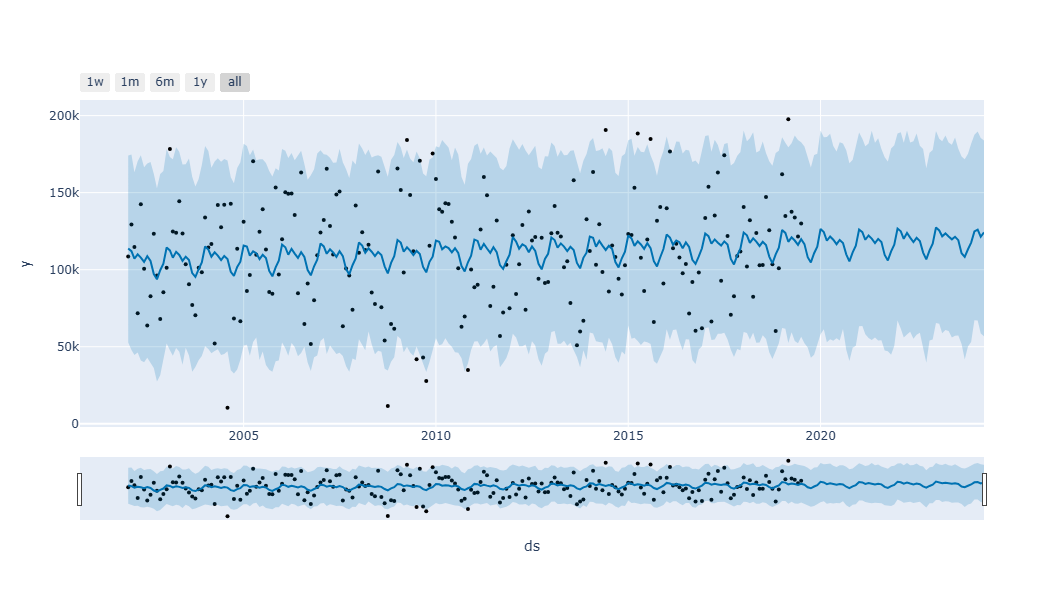

In [102]:
# visualise the model's predctions
plot_plotly(model_bt, test_fcast_bt)

In [103]:
# concatenate the predicted data and the actual data
y_yhat = pd.concat([df_sales, test_fcast_bt[['ds', 'yhat']].set_index('ds').loc[y_test.index[0]:]], axis=1)

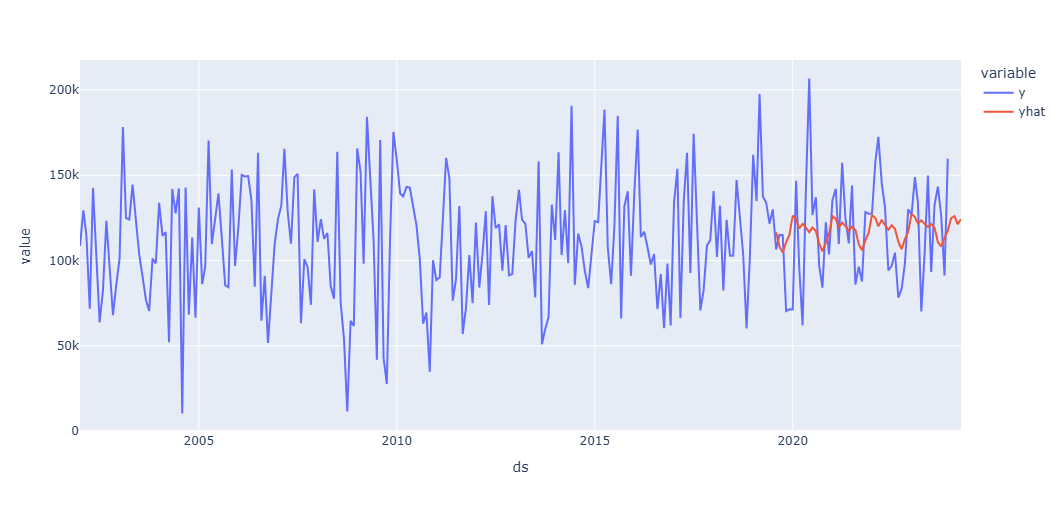

In [104]:
# visualise the actual sales with the predicted sales
fig = px.line(y_yhat, x=y_yhat.index, y=['y', 'yhat'], width=900, height=512)
fig.show()

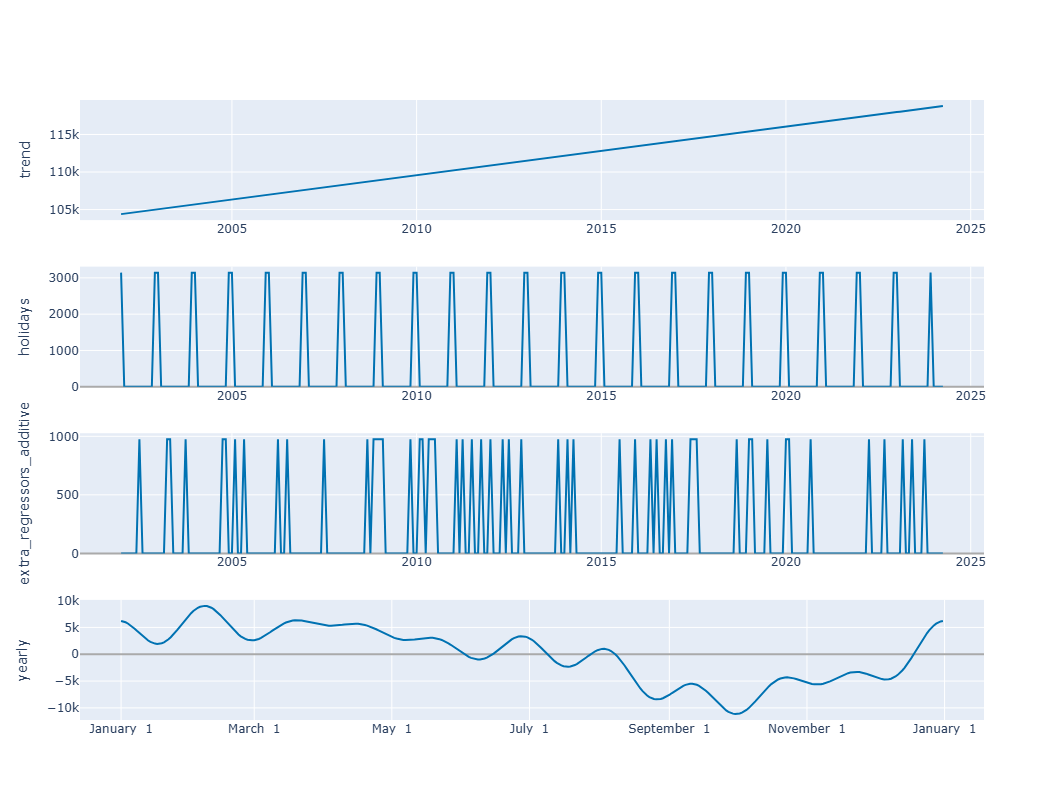

In [105]:
# plot the components of the time series
fig = plot_components_plotly(model_bt, forecast_bt)
fig.show()

#### Compare Forecast to Actual

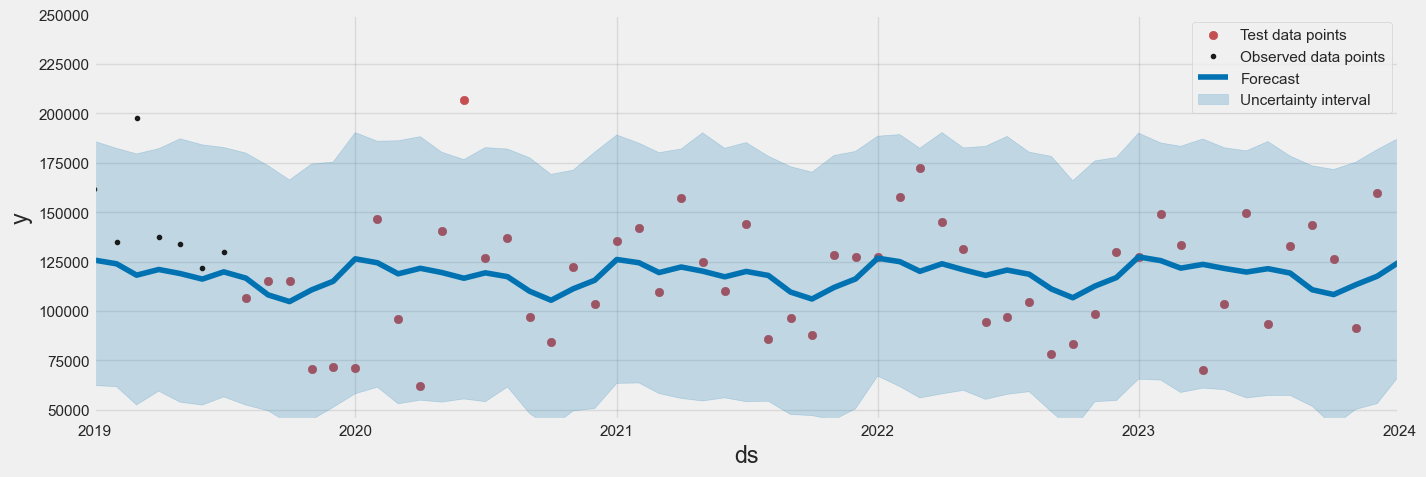

In [106]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(y_test.index, y_test['y'], color='r', label='Test data points')
fig = model_bt.plot(test_fcast_bt, ax=ax)
ax.legend()
ax.set_xbound(lower=pd.to_datetime('01-01-2019'), upper=pd.to_datetime('01-01-2024'))
ax.set_ylim(45_000, 250_000);

### Final Forecasting

In [107]:
# instantiate a model
model_ph = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'], 
                   seasonality_prior_scale=params_dict['seasonality_prior_scale'], interval_width=.95, holidays=holidays)

# add the promotion feature to the whole series
df_sales_copy = df_sales.copy()
df_sales_copy.reset_index(inplace=True)
df_sales_copy['is_promo'] = sales_data['Promotion']

# add the promotion feature to the model
model_ph.add_regressor('is_promo')


# Fit model with given params
model_ph.fit(df_sales_copy)

06:27:53 - cmdstanpy - INFO - Chain [1] start processing
06:27:53 - cmdstanpy - INFO - Chain [1] done processing


In [108]:
# define timestamps for the forecast
future_ph = model_ph.make_future_dataframe(periods=4, freq='MS')

# add the promotion feature to the series
future_ph['is_promo'] = sales_data['Promotion']
future_ph['is_promo'][future_ph['is_promo'].isna()] = 0

In [109]:
# make forecast for the next 4 months
forecast_ph = model_ph.predict(future_ph)
final_forecast = forecast_ph[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail(4)

In [110]:
final_forecast[['yhat']]

yhat
264  125639.817902
265  129491.059416
266  122988.998142
267  123912.816457

## Model Evaluation
- ### Final evaluation of models

In [111]:
# define a metric function to evaluate on some metrics
def metrics(actual, pred, name, train, to_return=True):
    print(f'==================={name}=========================')
    metric = evaluate_model(actual, pred, name, to_return)
    # scaled metrics
    rmsse = mean_squared_scaled_error(actual, pred, y_train=train, square_root=True)
    mase = mean_absolute_scaled_error(actual, pred, y_train=train)
    print(f'The Root Mean Squared Scaled Error for {name} = {rmsse}')
    print(f'The Mean Absolute Scaled Error for {name} = {mase}', end='\n\n')
    
    metric.extend([rmsse, mase])
    return (metric[0], metric[1:])

In [112]:
model_list = [(test, predict_holt_winters, 'model_holt_winters', train),
             (test, predict_arima, 'model_arima', train),
             (test, predict_final_arima, 'final_arima_model', train),
             (test, predict_sarima, 'model_sarima', train),
             (predict_df['y'], predict_df['yhat'], 'model_naive', y_train),
             (predict_bt_df['y'], predict_bt_df['yhat'], 'model_bt', y_train)]

metric_name = ['rmse', 'mape', 'mae', 'gmae', 'rmsse', 'mase']

In [113]:
def metric_evaluate(mod_params, metric_nm):
    df_list = []
    for mod in mod_params:
        df_list.append(metrics(*mod))
    df_dict = dict(df_list)
    metric_df = pd.DataFrame(df_dict, index=metric_nm)
    return metric_df.T

In [114]:
eval_df = metric_evaluate(model_list, metric_name)

===================model_holt_winters=========================
The mean absolute percentage error for model_holt_winters = 29.768812851949267
The root mean square error for model_holt_winters = 31772.046435667984
The MAPE from sktime for model_holt_winters = 0.2518280073201425
The mean absolute error from sktime for model_holt_winters = 24549.70027470819
The geometric mean absolute error from sktime for model_holt_winters = 17517.312967907677
The Root Mean Squared Scaled Error for model_holt_winters = 0.6821422674755758
The Mean Absolute Scaled Error for model_holt_winters = 0.6747914518420663

===================model_arima=========================
The mean absolute percentage error for model_arima = 24.42007904413652
The root mean square error for model_arima = 28276.836994834888
The MAPE from sktime for model_arima = 0.21008359614259461
The mean absolute error from sktime for model_arima = 21892.570650031586
The geometric mean absolute error from sktime for model_arima = 14779.57036

In [115]:
eval_df_copy = eval_df.sort_values('mase').copy()

In [116]:
eval_metrics = eval_df_copy.reset_index().rename(columns={'index': 'Models'})
eval_metrics

Models          rmse      mape           mae          gmae  \
0   final_arima_model  28166.735942  0.205109  21578.607676  12705.446416   
1         model_naive  29407.407813  0.206779  21885.445455  12268.014814   
2         model_arima  28276.836995  0.210084  21892.570650  14779.570364   
3            model_bt  28376.489542  0.219262  23049.430653  17107.017796   
4  model_holt_winters  31772.046436  0.251828  24549.700275  17517.312968   
5        model_sarima  37573.443604  0.305668  29442.077321  18628.456023   

      rmsse      mase  
0  0.604737  0.593126  
1  0.631374  0.601560  
2  0.607101  0.601756  
3  0.609240  0.633554  
4  0.682142  0.674791  
5  0.806698  0.809267

In [117]:
pd.melt(eval_metrics, id_vars='Models').sort_values('value').head(10)

Models variable     value
6    final_arima_model     mape  0.205109
7          model_naive     mape  0.206779
8          model_arima     mape  0.210084
9             model_bt     mape  0.219262
10  model_holt_winters     mape  0.251828
11        model_sarima     mape  0.305668
30   final_arima_model     mase  0.593126
31         model_naive     mase  0.601560
32         model_arima     mase  0.601756
24   final_arima_model    rmsse  0.604737